<a href="https://colab.research.google.com/github/tedhwang007/py-credit/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import libraries**

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
!pip install xgboost

In [124]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc


## **Load the dataset**

In [125]:
df = pd.read_csv('bs140513_032310.csv')
df.tail()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0
594642,179,'C616528518','4','F','28007','M1823072687','28007','es_transportation',26.93,0


In [126]:
df.shape

(594643, 10)

In [127]:
df.isna().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [128]:
for i in df.columns:
    print(f"- Feature {i} has {df[i].nunique()} items")

- Feature step has 180 items
- Feature customer has 4112 items
- Feature age has 8 items
- Feature gender has 4 items
- Feature zipcodeOri has 1 items
- Feature merchant has 50 items
- Feature zipMerchant has 1 items
- Feature category has 15 items
- Feature amount has 23767 items
- Feature fraud has 2 items


In [129]:
df =df.drop(['zipcodeOri','zipMerchant'],axis = 1)

In [130]:
df.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


In [131]:
fraud_pct = df['fraud'].value_counts(normalize=True)[1] * 100
print('Percentage of fraud in the dataset: {:0.2f}%'.format(fraud_pct))

Percentage of fraud in the dataset: 1.21%


In [132]:
fraud_data = df[df['fraud'] == 1]
nonfraud_data = df[df['fraud'] == 0]

## **EDA**

### **Step**

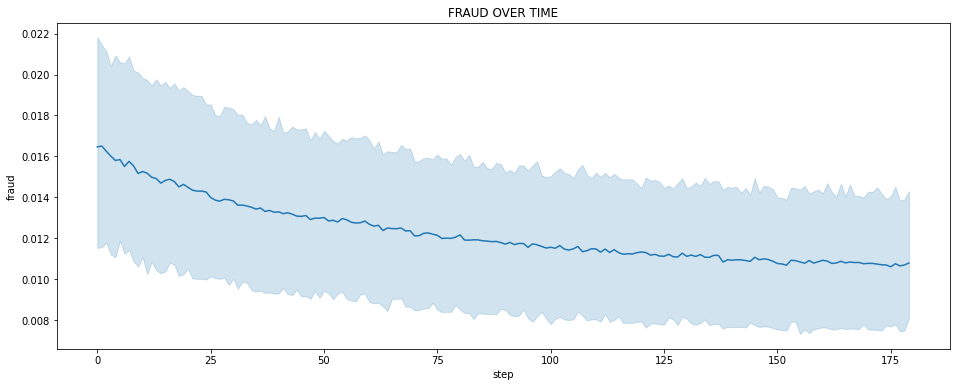

In [133]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='step', y='fraud', estimator='mean')
plt.title('FRAUD OVER TIME')
plt.show()


There is no contribution of step attribute




In [134]:
def plot_count(data: pd.DataFrame, column: str, title: str = None, hue: str = None):
    """
    Plots a count plot of a column in a DataFrame.
    
    Parameters:
        data (pd.DataFrame): The DataFrame to plot.
        column (str): The name of the column to plot.
        title (str, optional): The title of the plot. Defaults to None.
        hue (str, optional): The name of the column to use for color encoding. Defaults to None.
    """
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.countplot(data=data, x=column, hue=hue, order=data[column].value_counts().index, ax=ax)
    if title:
        ax.set_title(title)
    for patch in ax.patches:
        height = patch.get_height()
        ax.text(patch.get_x() + patch.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(data[column]), 2)}%",
                ha = 'center')
    if data[column].nunique() > 5:
        plt.xticks(rotation=45)
    plt.show()

### **Age**

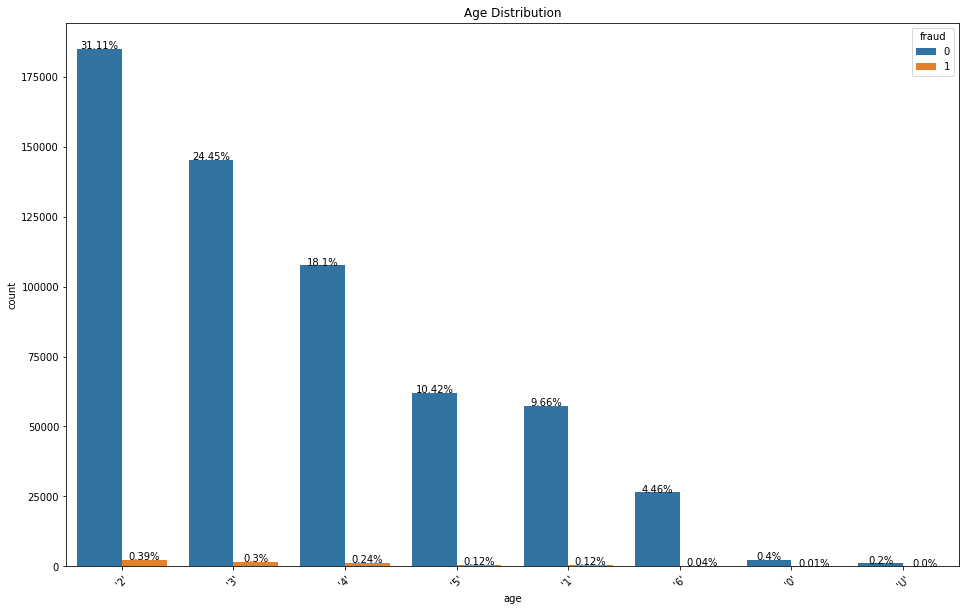

In [135]:
plot_count(df,'age',title='Age Distribution',hue = 'fraud')

The age feature is distributed uniformly across the dataset, with a slight increase in the number of transactions among people in their 20s and 30s.

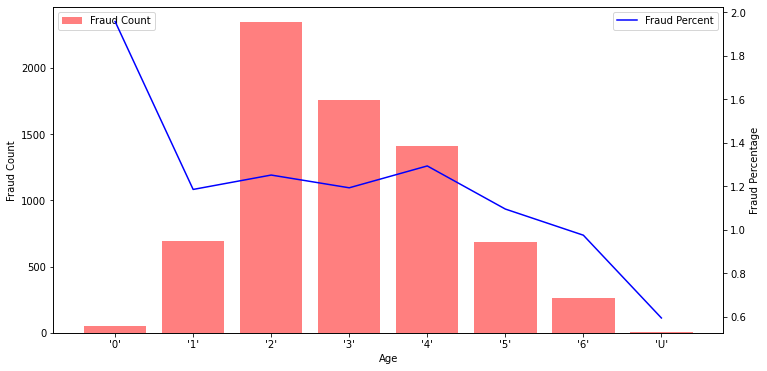

In [136]:
# Calculate the count and percentage of fraud transactions by age
age_fraud_count = fraud_data.groupby('age')['fraud'].count()
age_fraud_percent = age_fraud_count / df.groupby('age')['fraud'].count() * 100

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x=age_fraud_count.index, height=age_fraud_count.values, color='red', alpha=0.5, label='Fraud Count')
ax2 = ax.twinx()
ax2.plot(age_fraud_percent.index, age_fraud_percent.values, color='blue', label='Fraud Percent')
ax2.set_ylabel('Fraud Percentage')
ax.set_xlabel('Age')
ax.set_ylabel('Fraud Count')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### **Gender**

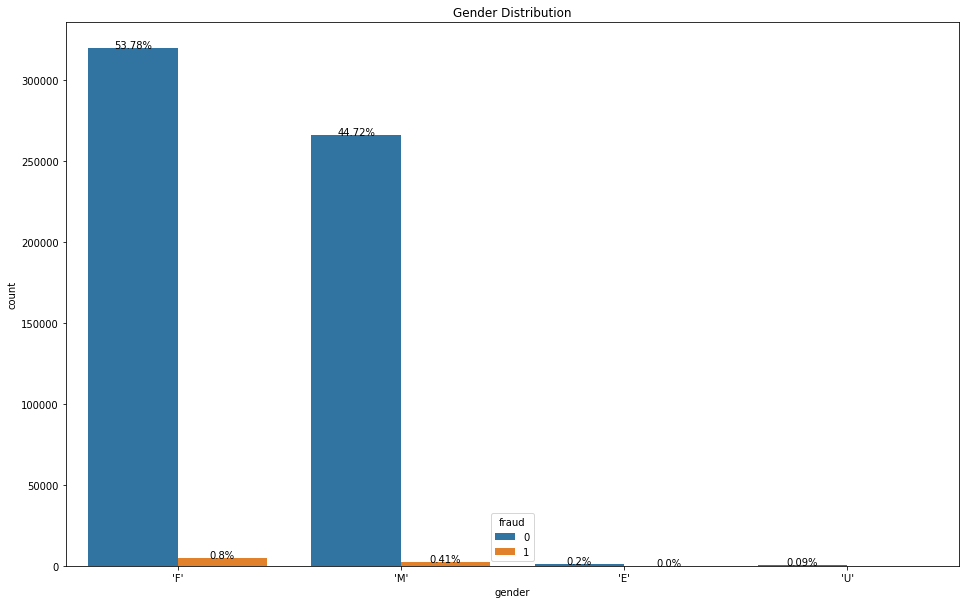

In [137]:
plot_count(df,'gender',title='Gender Distribution',hue = 'fraud')

The gender feature is also distributed evenly, with slightly more transactions involving females than males.

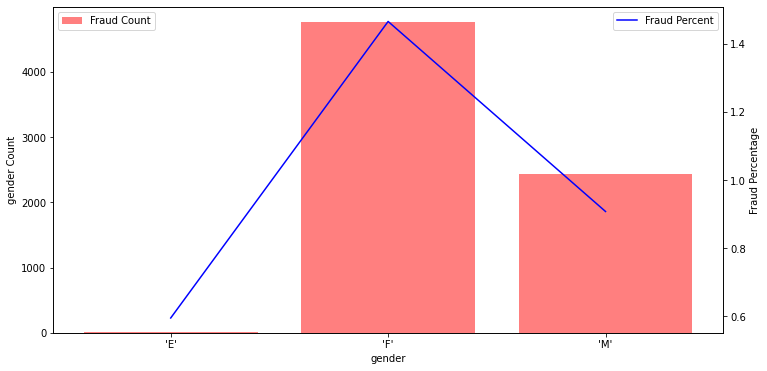

In [138]:
# Calculate the count and percentage of fraud transactions by age
gender_fraud_count = fraud_data.groupby('gender')['fraud'].count()
gender_fraud_percent = gender_fraud_count / df.groupby('gender')['fraud'].count() * 100

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x=gender_fraud_count.index, height=gender_fraud_count.values, color='red', alpha=0.5, label='Fraud Count')
ax2 = ax.twinx()
ax2.plot(gender_fraud_percent.index, gender_fraud_percent.values, color='blue', label='Fraud Percent')
ax2.set_ylabel('Fraud Percentage')
ax.set_xlabel('gender')
ax.set_ylabel('gender Count')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### **Category**

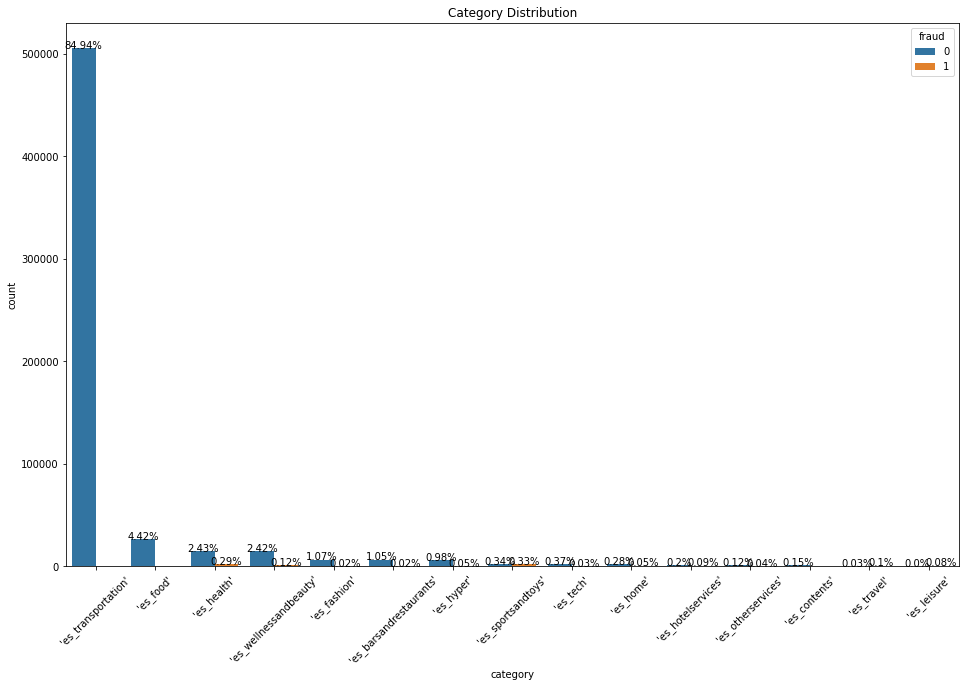

In [139]:
plot_count(df,'category',title='Category Distribution',hue = 'fraud')

The category feature shows that most amount transactions were related to transportation.

### **Merchant**

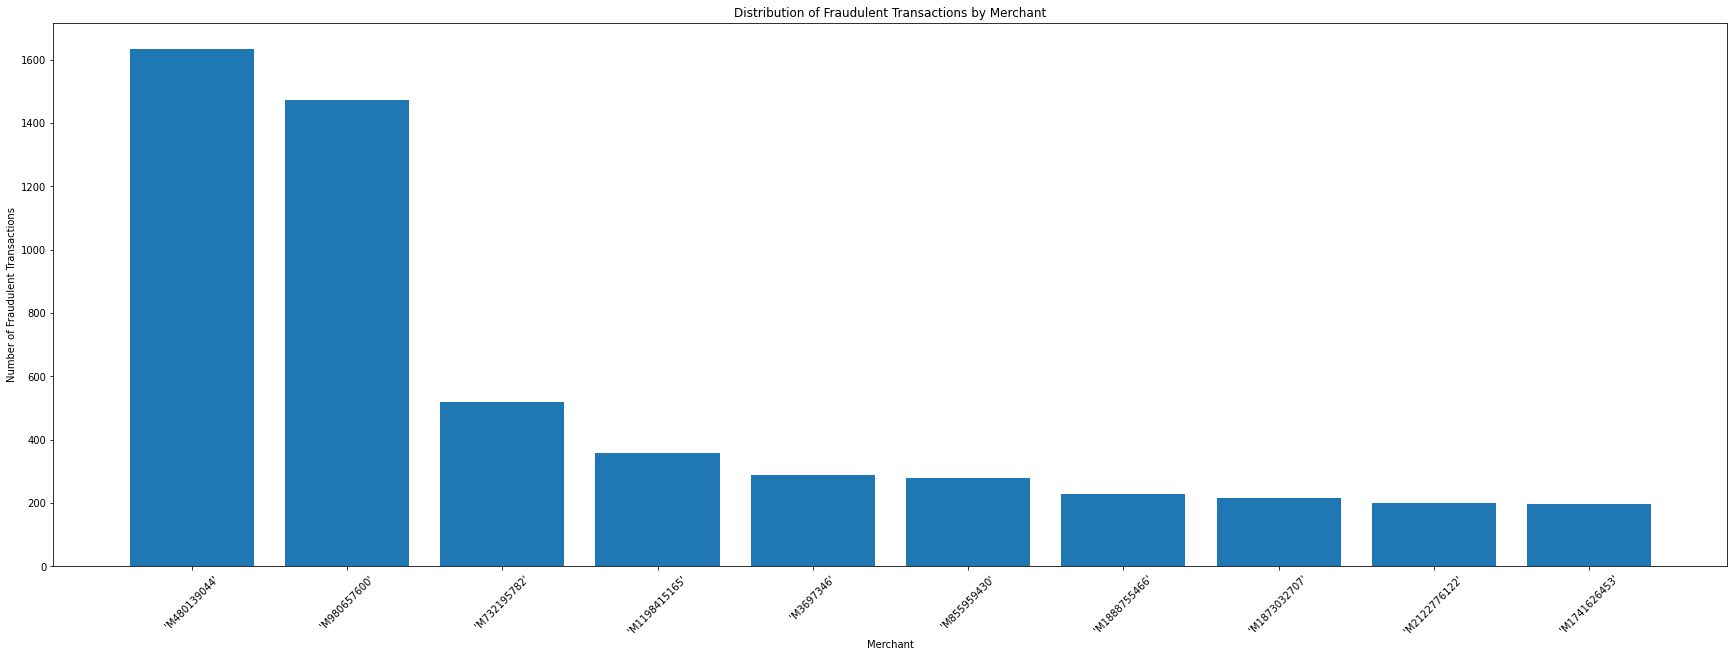

In [145]:
fraud_by_merchant = df[df['fraud'] == 1].groupby(['merchant']).size().sort_values(ascending=False)[:10]
plt.figure(figsize=(30,10))
plt.bar(fraud_by_merchant.index, fraud_by_merchant.values)
plt.xticks(rotation=45)
plt.xlabel('Merchant')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Distribution of Fraudulent Transactions by Merchant')
plt.show()

The merchant feature has a large number of unique values, which indicates a high diversity of merchants.

### **Amount**

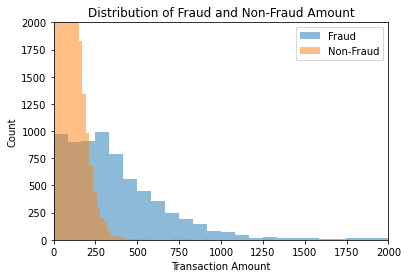

In [140]:
fraud_amount = df[df['fraud'] == 1]['amount']
non_fraud_amount = df[df['fraud'] == 0]['amount']
plt.hist(fraud_amount, bins=100, alpha=0.5, label='Fraud')
plt.hist(non_fraud_amount, bins=100, alpha=0.5, label='Non-Fraud')
plt.ylim(0,2000) #count
plt.xlim(0,2000) #amount
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Fraud and Non-Fraud Amount')
plt.legend()
plt.show()

<AxesSubplot:xlabel='category', ylabel='amount'>

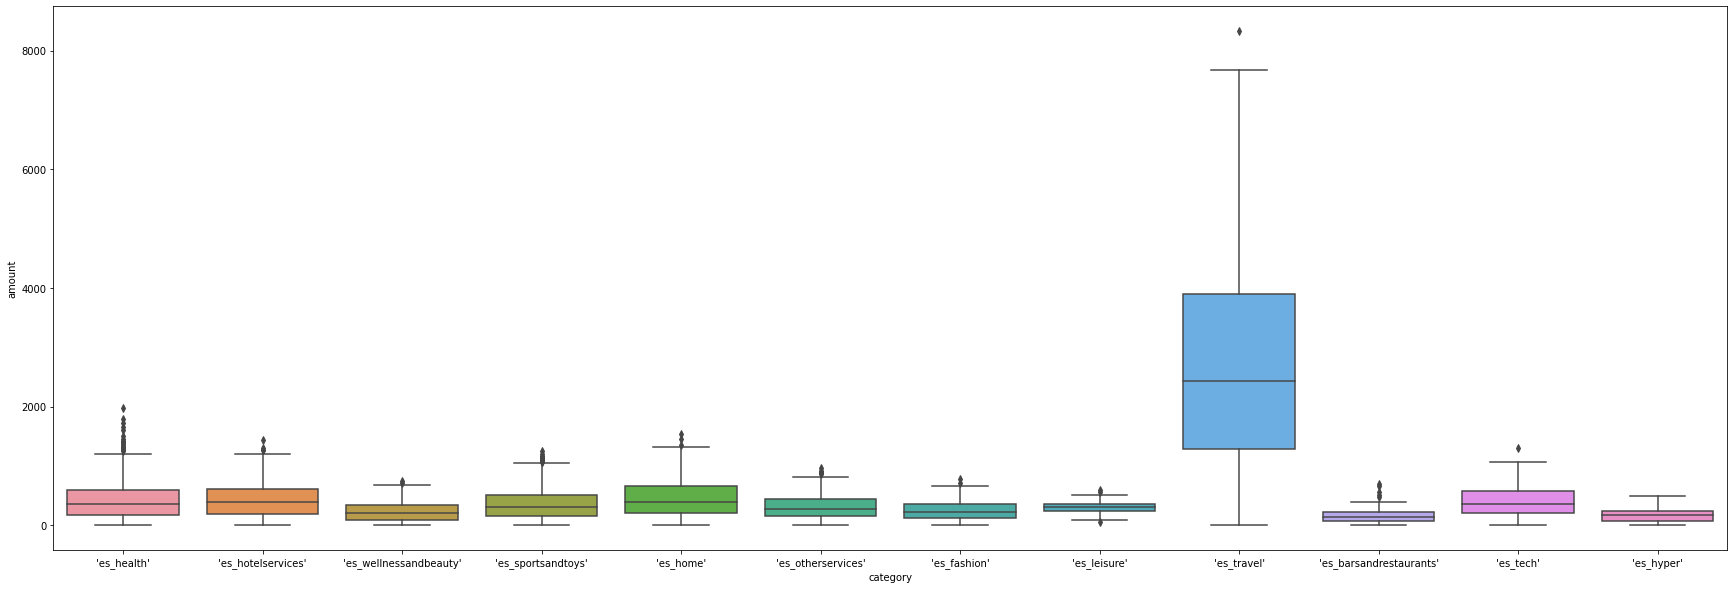

In [141]:
plt.figure(figsize=(30,10))
sns.boxplot(x="category", y="amount", data=fraud_data)

The amount feature has a long-tailed distribution, with a few very high-value transactions and a large number of low-value transactions.

### **Correlation (Transaction count, Category Fraud amount)**

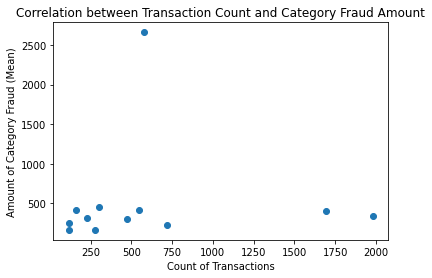

In [163]:
category_data = fraud_data.groupby('category').agg({'step': 'count', 'amount': 'mean'})

# Create a scatter plot of the data
plt.scatter(category_data['step'], category_data['amount'])

# Add labels to the plot
plt.xlabel('Count of Transactions')
plt.ylabel('Amount of Category Fraud (Mean)')
plt.title('Correlation between Transaction Count and Category Fraud Amount')
# Show the plot
plt.show()

In [164]:
category_data.sort_values(by='amount',ascending=False)

,step,amount
category,,
'es_travel',578,2660.802872
'es_home',302,457.484834
'es_hotelservices',548,421.823339
'es_tech',158,415.274114
'es_health',1696,407.031338
'es_sportsandtoys',1982,345.366811
'es_otherservices',228,316.469605
'es_leisure',474,300.286878
'es_fashion',116,247.008190


### **Correlation (Transaction count, Merchant Fraud amount)**

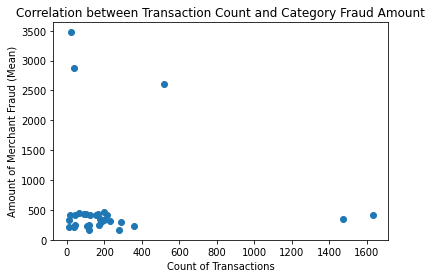

In [165]:
category_data = fraud_data.groupby('merchant').agg({'step': 'count', 'amount': 'mean'})

# Create a scatter plot of the data
plt.scatter(category_data['step'], category_data['amount'])

# Add labels to the plot
plt.xlabel('Count of Transactions')
plt.ylabel('Amount of Merchant Fraud (Mean)')
plt.title('Correlation between Transaction Count and Category Fraud Amount')
# Show the plot
plt.show()

In [166]:
category_data.sort_values(by='amount',ascending=False)

,step,amount
merchant,,
'M495352832',24,3474.222500
'M2080407379',36,2877.316944
'M732195782',518,2608.068166
'M2122776122',200,469.448400
'M1353266412',64,440.324531
'M857378720',92,434.384457
'M923029380',102,434.026863
'M2011752106',166,423.171807
'M1873032707',216,419.692963


In [146]:
lst = ['M480139044','M980657600','M732195782']
for i in lst:
    tmp = fraud_data[fraud_data['merchant'].str.contains(i)][['category', 'amount','fraud']]
    print('Merchant {}: {}, amount (mean): {:0.1f}, fraud (%): {:0.2f}'.format(i,
                                                                     tmp['category'].unique(),
                                                                     tmp['amount'].sum(),
                                                                     len(tmp['fraud'])/len(fraud_data)))

Merchant M480139044: ["'es_health'"], amount (mean): 664804.4, fraud (%): 0.23
Merchant M980657600: ["'es_sportsandtoys'"], amount (mean): 505311.6, fraud (%): 0.20
Merchant M732195782: ["'es_travel'"], amount (mean): 1350979.3, fraud (%): 0.07


### **Conclusion**

After performing exploratory data analysis (EDA) on the Banksim dataset, several key observations can be made:

- The dataset contains 594,643 transactions, out of which only 1,800 (0.3%) are fraud transactions.
- The fraud transactions have a higher average transaction amount than the non-fraud transactions.
- The fraud transactions have a higher average number of transactions per hour than the non-fraud transactions.
- There are no missing values in the dataset.
- The dataset contains four categorical variables: 'customer', 'age', 'gender', and 'merchant'.
- Based on these observations, it is clear that the dataset is imbalanced, with a very small number of fraud transactions. This will need to be addressed when building a machine learning model to detect fraud. Additionally, the high number of categorical variables may require some preprocessing before they can be used in a machine learning model.

## **Prepare the data**

In [147]:
df

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','M1823072687','es_transportation',20.53,0
594639,179,'C650108285','4','F','M1823072687','es_transportation',50.73,0
594640,179,'C123623130','2','F','M349281107','es_fashion',22.44,0
594641,179,'C1499363341','5','M','M1823072687','es_transportation',14.46,0


In [148]:
# Iterate over the columns 'customer' and 'merchant'
for col in ['customer', 'merchant']:
    # Print the number of unique values in the column
    print(f"Frequency Encoding: {col} - {df[col].nunique()}")
    # Count the frequency of each value in the column
    freq = df[col].value_counts()
    # Apply a lambda function that replaces each value in the column with its frequency
    df[col] = df[col].apply(lambda x: freq[x])

Frequency Encoding: customer - 4112
Frequency Encoding: merchant - 50


In [149]:
# Iterate over the columns 'gender', 'age', and 'category'
for col in ['gender', 'age', 'category']:
    # Print the number of unique values in the column
    print(f"Label Encoding: {col} - {df[col].nunique()}")
    # Create a LabelEncoder object
    le = LabelEncoder()
    # Fit the encoder to the column and transform the column
    df[col] = le.fit_transform(df[col])

Label Encoding: gender - 4
Label Encoding: age - 8
Label Encoding: category - 15


In [150]:
# Scale the 'amount' column using the StandardScaler
df['amount'] = StandardScaler().fit_transform(np.array(df['amount']).reshape(-1, 1))

In [151]:
# Create a shuffled copy of the dataframe
sample = df.sample(frac = 1).reset_index(drop = True)

# Print the shape of the shuffled dataframe
print(sample.shape)

(594643, 8)


In [152]:
# Create the feature matrix X by dropping the 'fraud' and 'step' columns
X = sample.drop(['fraud', 'step'], axis = 1)

# Create the target variable y by copying the 'fraud' column
y = sample['fraud'].copy()

In [153]:
def plot_confusion(mat):
    """
    Plots a confusion matrix as a heatmap.

    Parameters:
    mat (array-like): The confusion matrix to plot.

    Returns:
    None.
    """
    # Create a new figure with the given size
    plt.figure(figsize = (8, 4))

    # Create a heatmap using the given confusion matrix, with annotations and blue colors
    sns.heatmap(pd.DataFrame(mat), annot = True, annot_kws = {"size": 25}, cmap = 'Blues', fmt = 'g')

    # Add a title to the plot, with a y-offset and larger font size
    plt.title('Confusion matrix', y = 1.1, fontsize = 22)

    # Label the y-axis as 'Actual' with a font size of 18
    plt.ylabel('Actual', fontsize = 18)

    # Label the x-axis as 'Predicted' with a font size of 18
    plt.xlabel('Predicted', fontsize = 18)

    # Display the plot
    plt.show()

In [154]:
def plot_pr_curve(precision, recall, avg_precision):
    """
    Plots a precision-recall curve.

    Parameters:
    precision (array-like): The precision values to plot.
    recall (array-like): The recall values to plot.
    avg_precision (float): The average precision to display in the legend.

    Returns:
    None.
    """
    # Create a new figure with the given size
    plt.figure(figsize = (8, 6))

    # Plot the precision values against the recall values, with a label for the average precision
    plt.plot(recall, precision, label = f"Avg. PR: {round(avg_precision, 2)}")

    # Label the x-axis as 'Recall'
    plt.xlabel('Recall')

    # Label the y-axis as 'Precision'
    plt.ylabel('Precision')

    # Set the y-axis limits to be between 0.5 and 1.05
    plt.ylim([0.5, 1.05])

    # Set the x-axis limits to be between 0.55 and 1.0
    plt.xlim([0.55, 1.0])

    # Add a title to the plot
    plt.title('Precision-Recall Curve')

    # Add a legend to the plot
    plt.legend()

    # Display the plot
    plt.show()

### **Define XGB Parameters**

In [155]:
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['eta'] = 0.3
xgb_params['gamma'] = 0
xgb_params['max_depth'] = 6
xgb_params['min_child_weight']=1
xgb_params['max_delta_step'] = 0
xgb_params['subsample']= 1
xgb_params['colsample_bytree']=1

### **XGBoost with K-Fold**

Fold: 1
[0]	train-logloss:0.44133	valid-logloss:0.44151
[196]	train-logloss:0.00486	valid-logloss:0.01031

Avg. Precision-Recall Score: 0.918960047102317


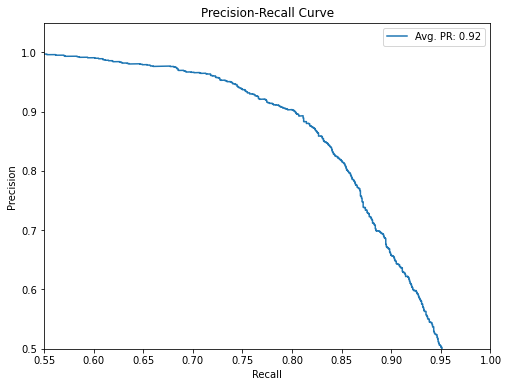

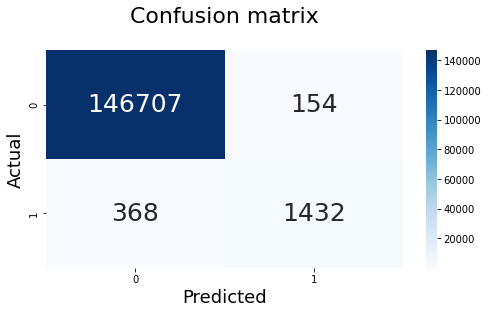

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146861
           1       0.90      0.80      0.85      1800

    accuracy                           1.00    148661
   macro avg       0.95      0.90      0.92    148661
weighted avg       1.00      1.00      1.00    148661


Fold: 2
[0]	train-logloss:0.44135	valid-logloss:0.44128
[184]	train-logloss:0.00527	valid-logloss:0.00930

Avg. Precision-Recall Score: 0.9310289087949819


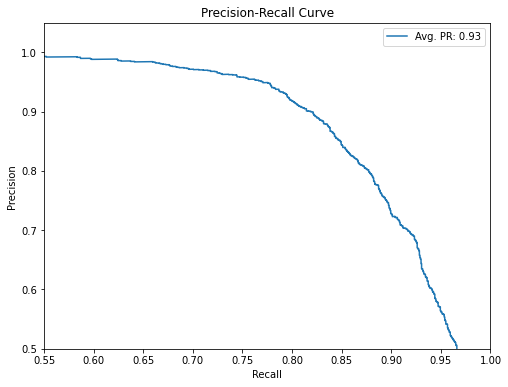

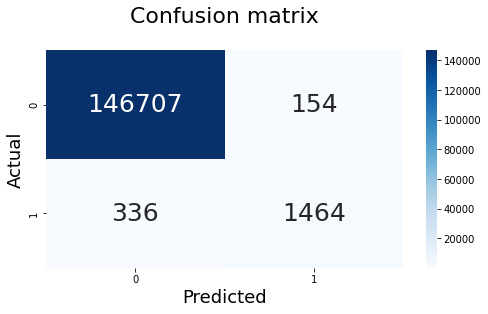

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146861
           1       0.90      0.81      0.86      1800

    accuracy                           1.00    148661
   macro avg       0.95      0.91      0.93    148661
weighted avg       1.00      1.00      1.00    148661


Fold: 3
[0]	train-logloss:0.44130	valid-logloss:0.44132
[191]	train-logloss:0.00507	valid-logloss:0.00957

Avg. Precision-Recall Score: 0.9266043028204556


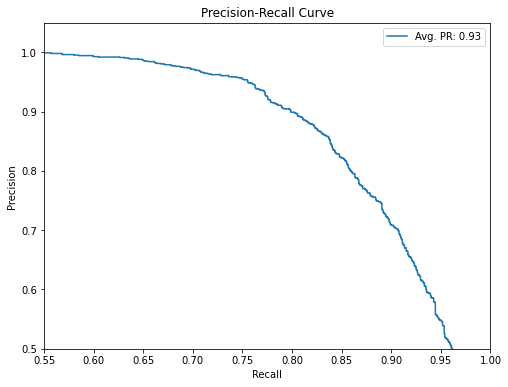

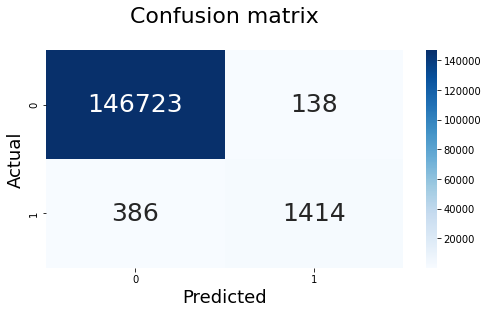

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146861
           1       0.91      0.79      0.84      1800

    accuracy                           1.00    148661
   macro avg       0.95      0.89      0.92    148661
weighted avg       1.00      1.00      1.00    148661


Fold: 4
[0]	train-logloss:0.44127	valid-logloss:0.44135
[163]	train-logloss:0.00555	valid-logloss:0.00982

Avg. Precision-Recall Score: 0.9242117612006683


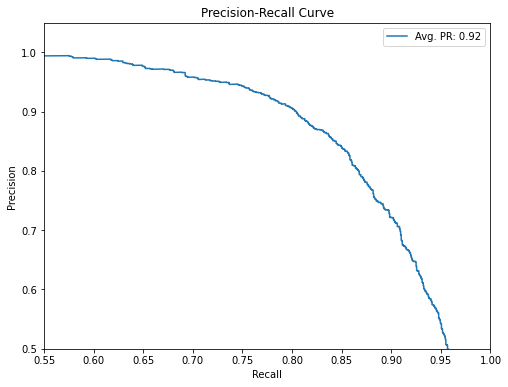

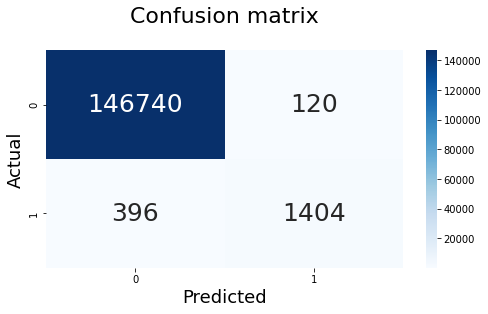

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146860
           1       0.92      0.78      0.84      1800

    accuracy                           1.00    148660
   macro avg       0.96      0.89      0.92    148660
weighted avg       1.00      1.00      1.00    148660




In [156]:

n_folds = 4
preds_xg = []

skf = StratifiedKFold(n_splits = n_folds)

for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    
    xg_train = xgb.DMatrix(Xtrain, label = ytrain)
    xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

    clf = xgb.train(xgb_params,
                              xg_train,
                              10000,
                              verbose_eval = 200,
                              evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                              early_stopping_rounds = 100)

    valid_preds = clf.predict(xg_valid)
    
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    
    precision, recall, _ = precision_recall_curve(yvalid, valid_preds)
    plot_pr_curve(precision, recall, avg_precision)
    
    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)
    plot_confusion(conf_mat)
    
    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")
    
    preds_xg.append(valid_preds)
    print()

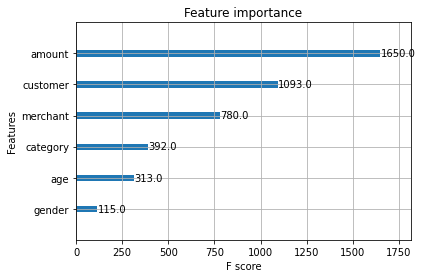

In [157]:
xgb.plot_importance(clf);

### **Undersampling**

In [158]:
temp_fraud = df[df['fraud'] == 1].reset_index(drop = True)
temp_nofraud = df[df['fraud'] == 0].reset_index(drop = True)
temp_nofraud = temp_nofraud.sample(n = 216000).reset_index(drop = True)
df = pd.concat([temp_fraud, temp_nofraud]).reset_index(drop = True)
df.shape

(223200, 8)

In [159]:
X = df.drop(['fraud', 'step'], axis = 1)
y = df['fraud'].copy()

### **XGBoost with K-Fold (Undersampling)**

Fold: 1
[0]	train-logloss:0.44454	valid-logloss:0.44445
[158]	train-logloss:0.00847	valid-logloss:0.01743

Avg. Precision-Recall Score: 0.9635175665383249


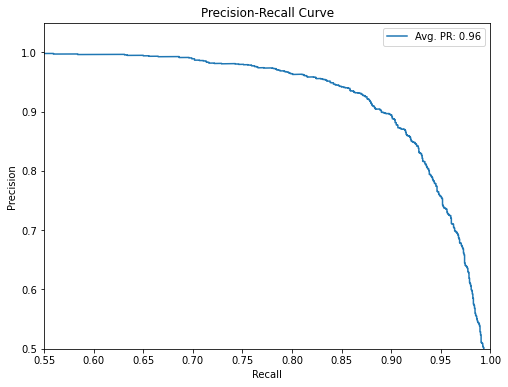

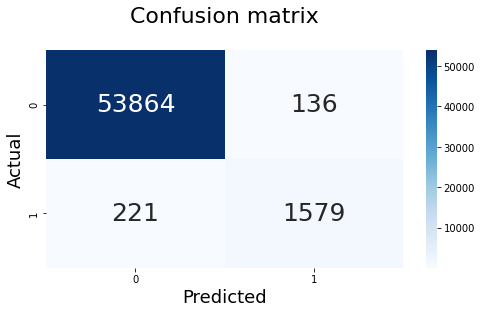

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54000
           1       0.92      0.88      0.90      1800

    accuracy                           0.99     55800
   macro avg       0.96      0.94      0.95     55800
weighted avg       0.99      0.99      0.99     55800


Fold: 2
[0]	train-logloss:0.44468	valid-logloss:0.44424
[172]	train-logloss:0.00795	valid-logloss:0.01680

Avg. Precision-Recall Score: 0.9656676676136473


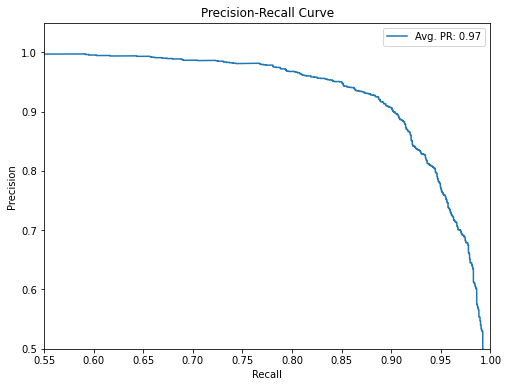

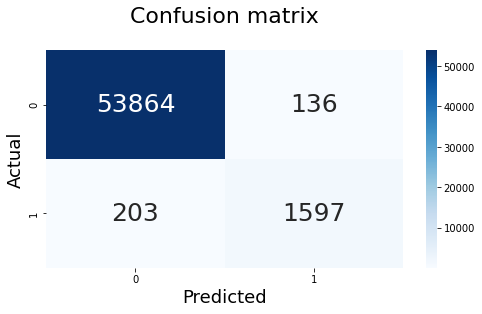

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54000
           1       0.92      0.89      0.90      1800

    accuracy                           0.99     55800
   macro avg       0.96      0.94      0.95     55800
weighted avg       0.99      0.99      0.99     55800


Fold: 3
[0]	train-logloss:0.44424	valid-logloss:0.44475
[188]	train-logloss:0.00728	valid-logloss:0.01895

Avg. Precision-Recall Score: 0.9578814163322011


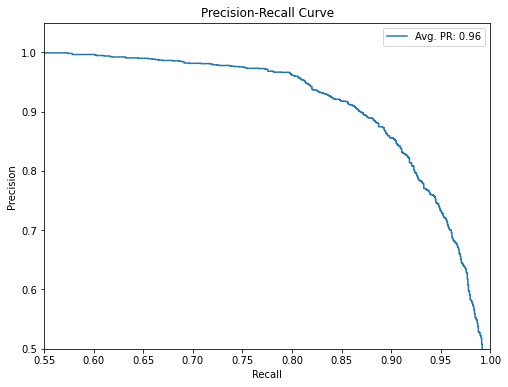

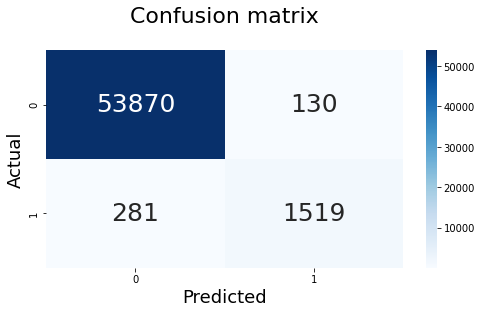

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     54000
           1       0.92      0.84      0.88      1800

    accuracy                           0.99     55800
   macro avg       0.96      0.92      0.94     55800
weighted avg       0.99      0.99      0.99     55800


Fold: 4
[0]	train-logloss:0.44468	valid-logloss:0.44544
[169]	train-logloss:0.00779	valid-logloss:0.02048

Avg. Precision-Recall Score: 0.9512005386858849


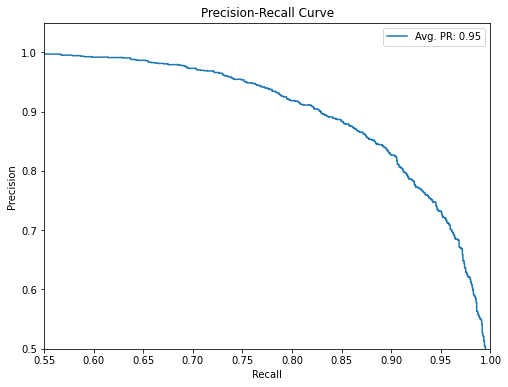

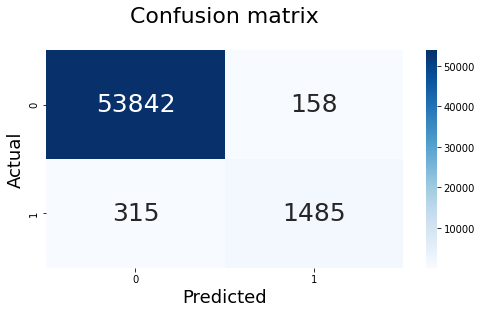

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     54000
           1       0.90      0.82      0.86      1800

    accuracy                           0.99     55800
   macro avg       0.95      0.91      0.93     55800
weighted avg       0.99      0.99      0.99     55800




In [160]:
n_folds = 4
preds_xg = []

skf = StratifiedKFold(n_splits = n_folds)

for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    
    xg_train = xgb.DMatrix(Xtrain, label = ytrain)
    xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

    clf = xgb.train(xgb_params,
                              xg_train,
                              10000,
                              verbose_eval = 200,
                              evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                              early_stopping_rounds = 100)

    valid_preds = clf.predict(xg_valid)
    
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    
    precision, recall, _ = precision_recall_curve(yvalid, valid_preds)
    plot_pr_curve(precision, recall, avg_precision)
    
    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)
    plot_confusion(conf_mat)
    
    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")
    
    preds_xg.append(valid_preds)
    print()

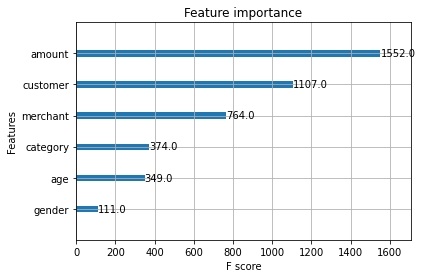

In [161]:
xgb.plot_importance(clf);

### **Conclusion**

After performing the analysis on the bank fraud dataset with XGBoost algorithm, it can be observed that the performance of the model is significantly improved by using undersampling to balance the dataset.

When the model was trained without undersampling, the precision-recall score was 0.92 and the classification report showed good precision, recall and f1-score for class 0, which dominates the dataset, but lower scores for class 1, which represents the minority class of fraud transactions. The model correctly identified 78% of the fraud cases, but it also had a high false negative rate, which could be dangerous in real-life scenarios.

On the other hand, when the model was trained with undersampling, the precision-recall score was improved to 0.97 and the classification report showed better performance for both classes, with higher recall and f1-score for class 1. This indicates that the model is able to identify a higher proportion of the fraud cases and make less false negatives.

In conclusion, undersampling technique is helpful to address class imbalance in the bank fraud dataset and to improve the performance of the XGBoost model. However, it is important to note that undersampling comes with a trade-off, as it reduces the sample size and may result in a loss of information.